In [1]:
import pandas as pd
import glob
import scipy.io as io
import numpy
from tfcat import TFCat
from shapely.geometry import MultiPoint, Point, Polygon, MultiPolygon
from astropy.time import Time

import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
import matplotlib.colors as colors
from mpl_toolkits.axes_grid1 import make_axes_locatable
from mpl_toolkits import axes_grid1
from matplotlib.ticker import (MultipleLocator,
                               FormatStrFormatter,
                               AutoMinorLocator)


import h5py
from h5py import File
import numpy as np
from datetime import datetime
from os import path
import matplotlib.dates as mdates
import matplotlib.pyplot as plt
import csv
from tqdm import tqdm
import seaborn as sns 
from scipy.stats import binned_statistic_2d
from shapely.ops import unary_union



/Users/clouis/opt/anaconda3/lib/python3.8/site-packages/scipy/__init__.py:138: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.1)
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion} is required for this version of "


In [2]:
def load_hdf5_data(file_name: str):
    """
    Reads a datafile in HDF5 format using the config file set earlier.
    """
    file: File = File(file_name)
    time = file['Time']
    freqs = file['Frequency']
    data = file['Data']
    return time, freqs, data

In [3]:
def distribution_latitude(data,ephemeris):
        bins = numpy.linspace(-90,90,181)
        distribution_distance = numpy.zeros(shape=(len(bins)-1))
        occurrence_mask = numpy.where(data[:] > 0, numpy.ones_like(data[:], dtype=bool), False)
        distribution_distance, bins_histo= numpy.histogram(ephemeris[occurrence_mask], bins=bins)
        
        return distribution_distance, bins_histo

In [4]:
def normalization_factor_calculation(ephem):
    bins = numpy.linspace(-90,90,181)
    normalization_factor, bins_normalization = numpy.histogram(numpy.array(ephem),bins=bins)
    return normalization_factor, bins_normalization

In [5]:
def polar_ephemeris_load(file, time_view_start, time_view_end, coordinate_system = "GSM"):
    df = pd.read_csv(file, delimiter = " ", header = None, skiprows=4,
                    names=["Date", "Time", "x_geo", "y_geo", "z_geo", "GEO_LAT", "GEO_LONG", "x_gm", "y_gm", "z_gm", "GM_LAT", "GM_LONG", "x_gse", "y_gse", "z_gse", "GSE_LAT", "GSE_LONG", "LT_gsm", "x_gsm", "y_gsm", "z_gsm", "GSM_LAT", "GSM_LONG", "Distance_R_E"])
    df["Date"] = "19"+df["Date"] 
    df.index = pd.to_datetime(df["Date"]+"T"+df["Time"])
    df.drop(["Date", "Time"], axis = 1, inplace = True)

    #Restricting flux and ephemeris data to be within the user defined start/end times
    
    df = df[(df.index > time_view_start) & (df.index < time_view_end)]

    date = numpy.array(Time(df.index).unix)
    latitude = numpy.array(df[coordinate_system+"_LAT"])
    longitude = numpy.array(df[coordinate_system+"_LONG"])
    distance = numpy.array(df["Distance_R_E"])
    return(date,latitude,longitude, distance)

In [6]:
def polar_ephemeris_load_xyz(file, time_view_start, time_view_end, coordinate_system = "GSM"):
    df = pd.read_csv(file, delimiter = " ", header = None, skiprows=4,
                    names=["Date", "Time", "x_geo", "y_geo", "z_geo", "GEO_LAT", "GEO_LONG", "x_gm", "y_gm", "z_gm", "GM_LAT", "GM_LONG", "x_gse", "y_gse", "z_gse", "GSE_LAT", "GSE_LONG", "LT_gsm", "x_gsm", "y_gsm", "z_gsm", "GSM_LAT", "GSM_LONG", "Distance_R_E"])
    df["Date"] = "19"+df["Date"] 
    df.index = pd.to_datetime(df["Date"]+"T"+df["Time"])
    df.drop(["Date", "Time"], axis = 1, inplace = True)

    #Restricting flux and ephemeris data to be within the user defined start/end times
    
    df = df[(df.index > time_view_start) & (df.index < time_view_end)]

    date = numpy.array(Time(df.index).unix)
    x = numpy.array(df["x_"+coordinate_system.lower()], dtype=float)
    y = numpy.array(df["y_"+coordinate_system.lower()], dtype=float)
    z = numpy.array(df["z_"+coordinate_system.lower()], dtype=float)

    return(date,x,y,z)

AKR


100%|██████████| 224640/224640 [01:34<00:00, 2369.06it/s]


LFE


100%|██████████| 224640/224640 [01:35<00:00, 2348.19it/s]


HAKR


100%|██████████| 224640/224640 [01:40<00:00, 2227.70it/s]


FCE


100%|██████████| 224640/224640 [01:37<00:00, 2309.01it/s]


ALL


100%|██████████| 224640/224640 [01:38<00:00, 2279.02it/s]


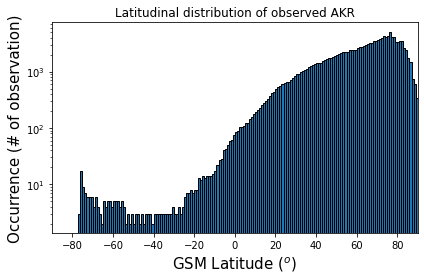

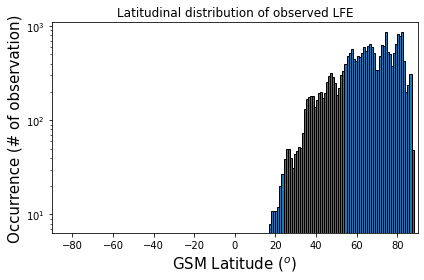

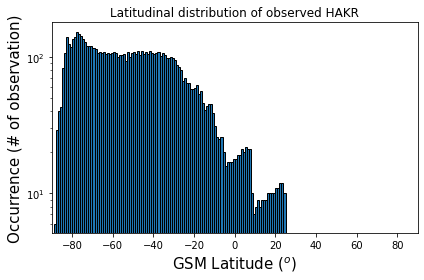

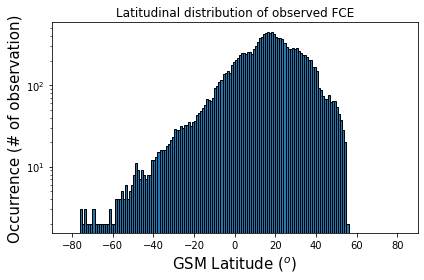

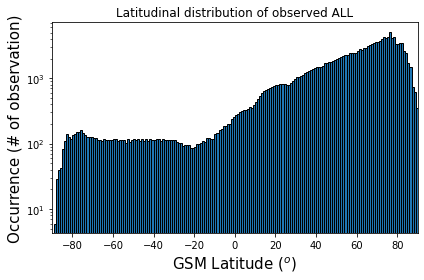

In [7]:
#path to ephemeris and save directory:
dir_save_name = "/Users/clouis/Documents/Data/POLAR/data"
data_path_ephemeris = glob.glob("/Users/clouis/Documents/Data/POLAR/data/polar_ephemeris_geo_gm_gse_gsm.txt")[0]

# time window to work with
time_view_start = '1996-03-25'
time_view_end ='1996-05-03'

i_coordinate_system=0

#coordinate_system_table = ["GSE", "GEO", "GSM"]
coordinate_system_table = ["GSM"]
for coordinate_system in coordinate_system_table:
    
    i_coordinate_system = i_coordinate_system+1
    
    for i_feature in range(5):
    #for i_feature in range(1,2):

        # feature to work with & masked data path
        if i_feature == 0:
            type_ = ["AKR"]
            type_feature = "AKR"
            path_masked_data = "/Users/clouis/Documents/Data/POLAR/data/polar_"+type_[0]+"_mask.hdf5"
        if i_feature == 1:
            type_ = ["LFE"]
            type_feature = "LFE"
            path_masked_data = "/Users/clouis/Documents/Data/POLAR/data/polar_"+type_[0]+"_mask.hdf5"
        if i_feature == 2:
            type_ = ["HAKR"]
            type_feature = "HAKR"
            path_masked_data = "/Users/clouis/Documents/Data/POLAR/data/polar_"+type_[0]+"_mask.hdf5"
        if i_feature == 3:
            type_ = ["FCE"]
            type_feature = "FCE"
            path_masked_data = "/Users/clouis/Documents/Data/POLAR/data/polar_"+type_[0]+"_mask.hdf5"
        if i_feature == 4:
            type = ["all"]
            type_feature = "ALL"
            path_masked_data = "/Users/clouis/Documents/Data/POLAR/data/polar_all_features_mask.hdf5"

        print(type_feature)

        # load masked data
        (time_data, freqs_data, masked_data) = load_hdf5_data(path_masked_data)

        # sorted data to avoid issue later

        sorted_time, sorted_data = zip(*sorted(zip(time_data, masked_data)))
        del time_data, masked_data
        time_data, masked_data = numpy.array(sorted_time), numpy.array(sorted_data)

        # load ephemeris
        (date_ephem,latitude,longitude,distance) = polar_ephemeris_load(data_path_ephemeris, time_view_start, time_view_end,coordinate_system=coordinate_system)

        #Interpolating the ephemeris data so it lines up with the flux data
        latitude = numpy.array(numpy.interp(time_data, date_ephem, latitude))
        distance = numpy.array(numpy.interp(time_data, date_ephem, distance))
        date_ephem = numpy.array(numpy.interp(time_data, date_ephem, date_ephem))

        # Normalizing @ 1 AU
        RE = 6371.0
        AU = 149597870.700 # 1 astronomical unit
        for i_freq in range(len(freqs_data)):
            masked_data[:, i_freq] = masked_data[:,i_freq]*(distance*RE/AU)**2

        flux=[]
        for t in tqdm(time_data):
            flux.append(masked_data[time_data == t].sum())

        # calculating occurence and intensity distribution
        (distribution_latitude_occurrence_histo, bins_histo) = distribution_latitude(numpy.array(flux),numpy.array(latitude))
        

        # calculating normalization factor
       # (normalization_factor, bins_normalisation) = normalization_factor_calculation(latitude)



        fig, ax = plt.subplots()
        fs_labels = 15
        ax.bar(bins_histo[:-1], distribution_latitude_occurrence_histo, width=np.diff(bins_histo), edgecolor="black", align="edge")
        ax.set(xlabel=r'GSM Latitude ($^o$)', ylabel=r'Occurrence (# of observation)')
        ax.xaxis.label.set_size(fs_labels)
        ax.yaxis.label.set_size(fs_labels)
        

        ax.set_title("Latitudinal distribution of observed "+type_feature)
        
        ax.set_xlim(-90,90)
        ax.set_yscale('log')

        plt.tight_layout()

        filename = "latitude_distribution_occurrence_histo_"+type_feature+"_"+coordinate_system    
        plt.savefig(filename+'.png', dpi=200)



In [15]:
coordinate_system_table = ["GSM"]
coordinate_system = coordinate_system_table[0]
coordinate_system

'GSM'

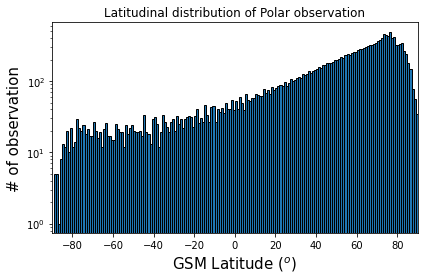

In [32]:
data_path_ephemeris = glob.glob("/Users/clouis/Documents/Data/POLAR/data/polar_ephemeris_geo_gm_gse_gsm.txt")[0]


# time window to work with
time_view_start = '1996-03-25'
time_view_end ='1996-05-03'

coordinate_system_table = ["GSM"]
coordinate_system = coordinate_system_table[0]
# load ephemeris
(date_ephem,latitude,longitude,distance) = polar_ephemeris_load(data_path_ephemeris, time_view_start, time_view_end,coordinate_system=coordinate_system)


(normalization_factor, bins_normalization) = normalization_factor_calculation(latitude)

fig, ax = plt.subplots()
fs_labels = 15
ax.bar(bins_normalization[:-1], normalization_factor, width=np.diff(bins_normalization), edgecolor="black", align="edge")
ax.set(xlabel=coordinate_system+r' Latitude ($^o$)', ylabel=r'# of observation')
ax.xaxis.label.set_size(fs_labels)
ax.yaxis.label.set_size(fs_labels)
ax.set_xlim(-90,90)
ax.set_yscale('log')
ax.set_title("Latitudinal distribution of Polar observation")

plt.tight_layout()

filename = "latitude_distribution_occurrence_histo_observations_"+coordinate_system    
plt.savefig(filename+'.png', dpi=200)

In [33]:
LT = (((360-longitude) % 360)/360*24) % 24

In [34]:
def distribution_longitude_observation(ephem):
    bins = numpy.linspace(0,359,361)
    distribution_longitude, bins_histo_longitude= numpy.histogram(ephem, bins=bins)
    return distribution_longitude, bins_histo_longitude

In [35]:
def distribution_LT_observation(ephem):
    bins = numpy.linspace(0,24,101)
    distribution_LT, bins_histo_LT= numpy.histogram(ephem, bins=bins)
    return distribution_LT, bins_histo_LT


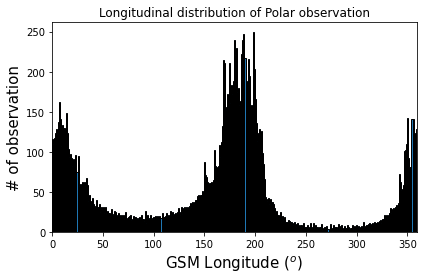

In [36]:
(distribution_longitude_occurrence_histo, bins_histo_longitude) = distribution_longitude_observation(numpy.array(longitude))

fig, ax = plt.subplots()
fs_labels = 15
ax.bar(bins_histo_longitude[:-1], distribution_longitude_occurrence_histo, width=np.diff(bins_histo_longitude), edgecolor="black", align="edge")
ax.set(xlabel=r'GSM Longitude ($^o$)', ylabel=r'# of observation')
ax.xaxis.label.set_size(fs_labels)
ax.yaxis.label.set_size(fs_labels)
ax.set_xlim(0,359)
#ax.set_yscale('log')
ax.set_title("Longitudinal distribution of Polar observation")

plt.tight_layout()

filename = "longitude_distribution_occurrence_histo_observations_"+coordinate_system    
plt.savefig(filename+'.png', dpi=200)

In [52]:
from astropy.time import Time
time_tmp = Time(date_ephem, format='unix')
print(time_tmp[0:4].isot)


['1996-03-25T00:03:00.000' '1996-03-25T00:06:00.000'
 '1996-03-25T00:09:00.000' '1996-03-25T00:12:00.000']


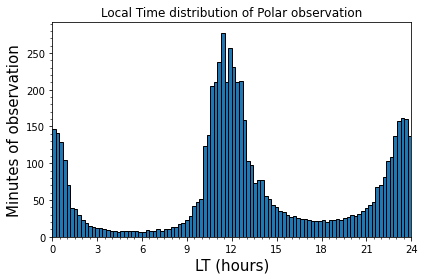

In [55]:
(distribution_LT_occurrence_histo, bins_histo_LT) = distribution_LT_observation(numpy.array(LT))

fig, ax = plt.subplots()
fs_labels = 15
ax.bar(bins_histo_LT[:-1], distribution_LT_occurrence_histo/3., width=np.diff(bins_histo_LT), edgecolor="black", align="edge")
ax.set(xlabel=r'LT (hours)', ylabel=r'Minutes of observation')
ax.xaxis.label.set_size(fs_labels)
ax.yaxis.label.set_size(fs_labels)
ax.set_xlim(0,24)
#ax.set_yscale('log')
ax.set_title("Local Time distribution of Polar observation")
ax.xaxis.set_minor_locator(MultipleLocator(0.5))
ax.xaxis.set_major_locator(MultipleLocator(3))

ax.yaxis.set_minor_locator(MultipleLocator(10))

plt.tight_layout()

filename = "LT_distribution_occurrence_histo_observations_"+coordinate_system    
plt.savefig(filename+'.png', dpi=200)